# Keras CV: YOLO Object Detection
In this notebook, I will use computer vision object detection techniques using the Keras machine learning library to classify fashion product image data from the Fashion-MNIST dataset. In this section, I will be building a custom computer vision model.

## Imports

In [1]:
# loads the libraries used in this notebook
! pip install tensorflow_text
import tensorflow_text
import tensorflow as tf
from tensorflow import feature_column
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found

In [2]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.4 MB/s eta 0:00:00


In [3]:
os.environ["KERAS_BACKEND"] = "torch"  # I will be using torch as it is a dependency in our environment.yml
import keras
import keras_cv
import tensorflow_datasets as tfds

In [4]:
! pip install datasets
import datasets

In [5]:
import math

## The Data

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
num_classes=10

In [7]:
fashion_mnist = datasets.load_dataset('fashion_mnist')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
train_fashion_ds = pd.DataFrame(fashion_mnist['train'])
test_fashion_ds = pd.DataFrame(fashion_mnist['test'])
train_fashion_ds.head()

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,9
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,3
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0


In [9]:
def convert_to_ds(feature):
    labels = []
    images = []
    def prepare_label_data(image, label, num_labels):
        images.append(np.array(image))
        labels.append(tf.one_hot(label, num_labels))
    feature.apply(lambda x: prepare_label_data(x['image'], x['label'], 10), axis=1)
    X_ds = tf.data.Dataset.from_tensor_slices(images)
    y_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip(X_ds, y_ds)

In [27]:
train_fashion_xy = convert_to_ds(train_fashion_ds)
test_fashion_xy = convert_to_ds(test_fashion_ds)

In [28]:
resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

In [29]:
def package_inputs(image, label):
    # Duplicate the channel to create a 3-channel image
    rgb_image = tf.image.grayscale_to_rgb(tf.expand_dims(image, axis=-1))
    image = tf.cast(rgb_image, tf.float32)
    return {"images": resizing(image), "labels": label}

In [30]:
train_ds = train_fashion_xy.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = test_fashion_xy.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

In [32]:
batch_train_sample = next(iter(train_ds.take(1)))
image_batch = batch_train_sample["images"]
label_batch = batch_train_sample["labels"]

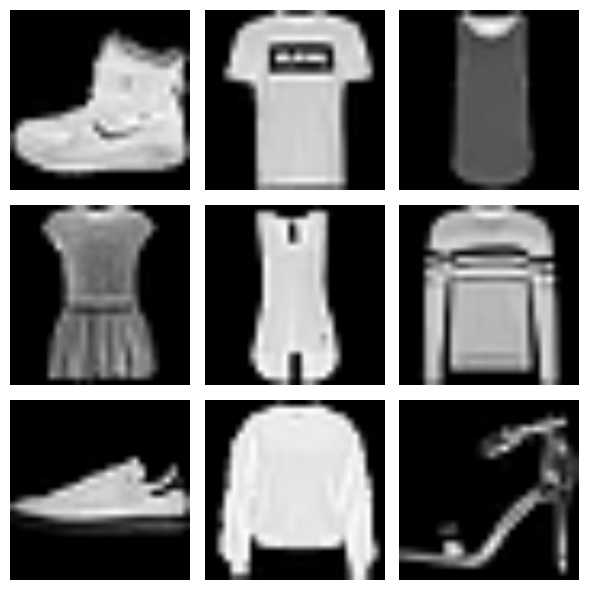

In [33]:
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [34]:
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]


In [35]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
batch_train_sample = next(iter(train_ds.take(1)))
image_batch = batch_train_sample["images"]
label_batch = batch_train_sample["labels"]

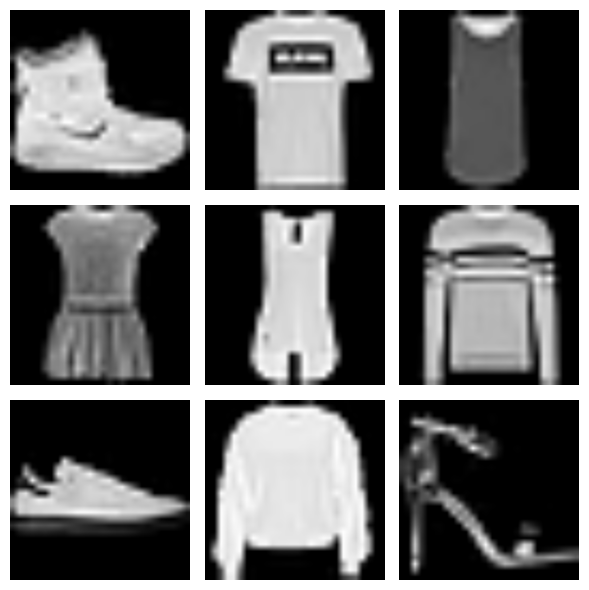

In [36]:
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [37]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

# The Model

In [38]:
from keras.optimizers import schedules
from keras import optimizers, losses, metrics, ops
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)

In [39]:
total_images = 9000
total_steps = (total_images // BATCH_SIZE) * 1 # 1 is # Epochs
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

In [40]:
backbone = keras_cv.models.EfficientNetV2B0Backbone()
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

In [41]:
loss = losses.CategoricalCrossentropy(label_smoothing=0.1)

In [42]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        metrics.CategoricalAccuracy(name="accuracy"),
        metrics.TopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
    ],
)

In [43]:
model.fit(
    train_ds,
    epochs=1,
    validation_data=eval_ds,
    verbose=1,
)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 473s 198ms/step - accuracy: 0.2256 - loss: 3.6310 - top-5-accuracy: 0.7629 - val_accuracy: 0.3272 - val_loss: 1.8137 - val_top-5-accuracy: 0.9469


## Conclusion

Using a preset model architecture backbone for computer vision tasks (efficient net - no pre-training/weights used), I was able to train a model that has minimal accuracy for detecting black and white images of articles of clothing, and classifying them across 10 different labels.

This may simply be a case of having too little training data, or having a pre-processing pipeline that needs to be refined a bit further. This experience taught me the complexity of training a custom keras model!